In [3]:
!pip install uproot3 
!pip install scikit-learn


In [90]:
import uproot3 as uproot
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit
from scipy.stats import cauchy

In [91]:
m_mu=0.10565837
m_e=0.0005115678
m_pi=0.1349999999
m_DH=0.8128

## Analysis of ACTS Output

The output of ACTS consists of root files. Two main files are particularly interesting to analyze:

### 1. Trackstates Fitter
- **Description**: Provides information for each tracking layer, including hits position layer by layer.
- **Detailed Description**: Can be found in the following header file:
  [RootTrackStatesWriter.hpp](https://github.com/acts-project/acts/blob/main/Examples/Io/Root/include/ActsExamples/Io/Root/RootTrackStatesWriter.hpp)

### 2. Tracksummary Fitter
- **Description**: Provides the results of the track fitting algorithm, including Q/P, Theta, Phi, as well as the truth information for vertex position and momentum.
- **Detailed Description**: Can be found in the following header file:
  [RootTrackSummaryWriter.hpp](https://github.com/acts-project/acts/blob/main/Examples/Io/Root/include/ActsExamples/Io/Root/RootTrackSummaryWriter.hpp)

### Example Analysis
This example demonstrates an analysis of the decay of a dark Higgs into two muons. It shows how to extract information from the ACTS output using `uproot` and provides examples of plots for momentum resolutions and invariant mass resolution.

#### Steps:
1. **[Extract Information](#function-to-extract-information-from-trackstates_fitterroot-and-tracksummary_fitterroot)**: Use `uproot` to extract relevant data from the root files.
2. **[Plot Momentum Resolutions](#plot-of-the-momentum-resolution)**: Generate plots to visualize the momentum resolutions.
3. **[Plot Invariant Mass Resolution](#plot-of-the-mass-resolution)**: Generate plots to visualize the invariant mass resolution.



### Extract Information ACTS output
 
#### Function to extract information from trackstates_fitter.root and tracksummary_fitter.root

Each branch of the root file is converted into numpy arrays using uproot with specific shape:
- **Trackstate fitter**: array of array for each tracking layer
- **Tracksummary fitter**: array of array for each particle that decays for each event (e.g., LLP decay into muons, array of array for each muon)

In [92]:
def tracks_reco(filename):
    # Open the ROOT file
    if 'trackstates' not in filename:
        raise ValueError("The filename must contain 'trackstates'")
    
    file = uproot.open(filename)

    # Access the TTree
    tree = file["trackstates"]

    # Read the branches into numpy arrays
    
    # Event information
    event_nr = tree["event_nr"].array()
    multiTraj_nr = tree["multiTraj_nr"].array()
    subTraj_nr = tree["subTraj_nr"].array()
    nMeasurements = tree["nMeasurements"].array()
    
    # Truth hits information
    t_x = tree["t_x"].array()
    t_y = tree["t_y"].array()
    t_z = tree["t_z"].array()
    t_r = tree["t_r"].array()
    t_eLOC0 = tree["t_eLOC0"].array()
    t_eLOC1 = tree["t_eLOC1"].array()
    t_ePHI = tree["t_ePHI"].array()
    t_eTHETA = tree["t_eTHETA"].array()
    t_eQOP = tree["t_eQOP"].array()
    t_eT = tree["t_eT"].array()
    nStates = tree["nStates"].array()

    layer_id = tree["layer_id"].array()


    # Hit information
    
    l_x_hit = tree["l_x_hit"].array()
    l_y_hit = tree["l_y_hit"].array()
    g_x_hit = tree["g_x_hit"].array()
    g_y_hit = tree["g_y_hit"].array()
    g_z_hit = tree["g_z_hit"].array()
    res_x_hit = tree["res_x_hit"].array()
    res_y_hit = tree["res_y_hit"].array()
    err_x_hit = tree["err_x_hit"].array()
    err_y_hit = tree["err_y_hit"].array()
    pull_x_hit = tree["pull_x_hit"].array()
    pull_y_hit = tree["pull_y_hit"].array()
    dim_hit = tree["dim_hit"].array()

    g_x_smt=tree["g_x_smt"].array()
    g_y_smt=tree["g_y_smt"].array()
    g_z_smt=tree["g_z_smt"].array()
    eQOP_smt=tree["eQOP_smt"].array()
    res_eQOP_smt=tree["res_eQOP_smt"].array()
    err_eQOP_smt=tree["err_eQOP_smt"].array()
    chi2=tree["chi2"].array()

    t_p=1/np.abs(t_eQOP)
    p_fit=1/np.abs(eQOP_smt)
    g_r_hit=np.sqrt(g_x_hit**2+g_y_hit**2+g_z_hit**2)
    g_R_hit=np.sqrt(g_y_hit**2+g_z_hit**2)

    t_p_full=t_p[[x.shape[0] >= 6 for x in t_p]]
    p_fit_full=p_fit[[x.shape[0] >= 6 for x in p_fit]]

    t_eQOP_full=t_eQOP[[x.shape[0] >= 6 for x in t_eQOP]]
    charge_full=np.sign(t_eQOP_full)
    g_z_hit_full=g_z_hit[[x.shape[0] >= 6 for x in g_z_hit]]
    g_y_hit_full=g_y_hit[[x.shape[0] >= 6 for x in g_y_hit]]
    g_R_hit_full=g_R_hit[[x.shape[0] >= 6 for x in g_R_hit]]



    # Flatten variables into 1D numpy arrays

    g_x_hit_1d = g_x_hit.flatten()
    g_y_hit_1d = g_y_hit.flatten()
    g_z_hit_1d = g_z_hit.flatten()

    
    t_p_bef_mag=t_p_full[:,3] 
    t_p_aft_mag=t_p_full[:,2] 

    g_R_hit_bef_mag=g_R_hit_full[:,3]  
    g_R_hit_aft_mag=g_R_hit_full[:,2]

    g_y_hit_bef_mag=g_y_hit_full[:,3] 
    g_z_hit_bef_mag=g_z_hit_full[:,3]

    g_y_hit_aft_mag=g_y_hit_full[:,2] 
    g_z_hit_aft_mag=g_z_hit_full[:,2]
    
    Track_param={
        'event_nr':event_nr,
        't_p':t_p,
        'g_x_hit_1d':g_x_hit_1d,
        'g_y_hit_1d':g_y_hit_1d,
        'g_z_hit_1d':g_z_hit_1d,
        'g_R_hit_full':g_R_hit_full,
        't_p_bef_mag':t_p_bef_mag,
        't_p_aft_mag':t_p_aft_mag,
        'g_y_hit_full':g_y_hit_full,
        'g_z_hit_full':g_z_hit_full,
        'g_R_hit_bef_mag': g_R_hit_bef_mag,
        'g_R_hit_aft_mag': g_R_hit_aft_mag,
        'g_y_hit_bef_mag': g_y_hit_bef_mag,
        'g_y_hit_aft_mag': g_y_hit_aft_mag,
        'p_fit':p_fit,

    }
    
    return(Track_param)




In [93]:
def reco_analysis(filename,LLP_decay=False, m_decay=m_mu):
    if 'tracksummary' not in filename:
        raise ValueError("The filename must contain 'trackstates'")
    file = uproot.open(filename)
    tree = file["tracksummary"]

    # Reading necessary branches from the root file
    nMeas=tree.array("nMeasurements")
    event_nr = tree.array("event_nr")
    # t_ means truth information
    t_charge = tree.array("t_charge")
    t_time = tree.array("t_time")
    # Vertex position
    t_vx = tree.array("t_vx")
    t_vy = tree.array("t_vy")
    t_vz = tree.array("t_vz")
    # Momentum information
    t_px = tree.array("t_px")
    t_py = tree.array("t_py")
    t_pz = tree.array("t_pz")
    t_p = tree.array("t_p")
    t_theta = tree.array("t_theta")
    t_phi = tree.array("t_phi")
    t_eta = tree.array("t_eta")
    t_charge = tree.array("t_charge")
    
    # Information from tracking fit
    
    ePHI_fit = tree.array("ePHI_fit")
    eTHETA_fit = tree.array("eTHETA_fit")
    eQOP_fit = tree.array("eQOP_fit")
    

    # Calculate relevant variables

    p_fit = 1.0 / abs(eQOP_fit)
    pz_fit = p_fit * np.cos(eTHETA_fit)
    px_fit = p_fit * np.sin(eTHETA_fit) * np.cos(ePHI_fit)
    py_fit = p_fit * np.sin(eTHETA_fit) * np.sin(ePHI_fit)

    # Relative residuals (Resolution) on momentum
    res_pz_fit_rel = (pz_fit - t_pz) / t_pz   
    res_px_fit_rel = (px_fit - t_px) / t_px
    res_py_fit_rel = (py_fit - t_py) / t_py
    res_p_fit_rela =(p_fit - t_p) / t_p
    res_p_fit_rel_abs = np.abs(p_fit - t_p) / t_p

    # Flattening arrays
    res_eQOP_fit_1d = (eQOP_fit + 1 / t_p).flatten()
    event_nr_1d = event_nr.flatten()
    t_charge_1d = t_charge.flatten()
    t_time_1d = t_time.flatten()
    t_vx_1d = t_vx.flatten()
    t_vy_1d = t_vy.flatten()
    t_vz_1d = t_vz.flatten()
    t_px_1d = t_px.flatten()
    t_py_1d = t_py.flatten()
    t_pz_1d = t_pz.flatten()
    t_p_1d = t_p.flatten()
    t_theta_1d = t_theta.flatten()
    t_phi_1d = t_phi.flatten()
    t_eta_1d = t_eta.flatten()

    pz_fit_1d=pz_fit.flatten()
    px_fit_1d=px_fit.flatten()
    py_fit_1d=py_fit.flatten()  
    p_fit_1d=p_fit.flatten()
      
    res_pz_fit_rel_1d = res_pz_fit_rel.flatten()
    res_px_fit_rel_1d = res_px_fit_rel.flatten()
    res_py_fit_rel_1d = res_py_fit_rel.flatten()    
    res_p_fit_rela_1d = res_p_fit_rela.flatten()
    res_p_fit_rel_abs_1d = res_p_fit_rel_abs.flatten()

    if(LLP_decay):
        t_px_2D = t_px[[x.shape[0] >= 2 for x in t_px]]
        t_py_2D = t_py[[x.shape[0] >= 2 for x in t_py]]
        t_pz_2D = t_pz[[x.shape[0] >= 2 for x in t_pz]]
        t_p_2D = t_p[[x.shape[0] >= 2 for x in t_p]]
        px_fit_2D = px_fit[[x.shape[0] >= 2 for x in px_fit]]
        py_fit_2D = py_fit[[x.shape[0] >= 2 for x in py_fit]]
        pz_fit_2D = pz_fit[[x.shape[0] >= 2 for x in pz_fit]]
        p_fit_2D = p_fit[[x.shape[0] >= 2 for x in p_fit]]

        # Extracting first and second particles' momenta
        # Truth
        t_px_1, t_px_2 = t_px_2D[:, 0], t_px_2D[:, 1]
        t_py_1, t_py_2 = t_py_2D[:, 0], t_py_2D[:, 1]
        t_pz_1, t_pz_2 = t_pz_2D[:, 0], t_pz_2D[:, 1]
        t_p_1, t_p_2 = t_p_2D[:, 0], t_p_2D[:, 1]
        
        # Fitted information on momentum
        px_fit_1, px_fit_2 = px_fit_2D[:, 0], px_fit_2D[:, 1]
        py_fit_1, py_fit_2 = py_fit_2D[:, 0], py_fit_2D[:, 1]
        pz_fit_1, pz_fit_2 = pz_fit_2D[:, 0], pz_fit_2D[:, 1]
        p_fit_1, p_fit_2 = p_fit_2D[:, 0], p_fit_2D[:, 1]

        # Calculating the invariant mass
        mu = m_decay
        t_E1 = np.sqrt(mu**2 + t_p_1**2)
        t_E2 = np.sqrt(mu**2 + t_p_2**2)
        E1_fit = np.sqrt(mu**2 + p_fit_1**2)
        E2_fit = np.sqrt(mu**2 + p_fit_2**2)

        t_m2 = (t_E1 + t_E2)**2 - (t_px_1 + t_px_2)**2 - (t_py_1 + t_py_2)**2 - (t_pz_1 + t_pz_2)**2
        t_m = np.sqrt(np.abs(t_m2))
        
        m2_fit = (E1_fit + E2_fit)**2 - (px_fit_1 + px_fit_2)**2 - (py_fit_1 + py_fit_2)**2 - (pz_fit_1 + pz_fit_2)**2
        m_fit = np.sqrt(np.abs(m2_fit))

        m_fit_t_m_ratio = (m_fit - t_m) / t_m
        t_mass = np.round(np.mean(t_m), 4)

        eQOP_fit_2D = eQOP_fit[[x.shape[0] >= 2 for x in eQOP_fit]]
        t_charge_2D = t_charge[[x.shape[0] >= 2 for x in t_charge]]
        eQOP_fit_2D_1d = eQOP_fit_2D.flatten()
        t_charge_2D_1d = t_charge_2D.flatten()

        Fitted_var = {
            'm_fit': m_fit,
            'Mass_value': t_mass,
            'mass_rel': m_fit_t_m_ratio,
            'qop': eQOP_fit_2D_1d,
            't_charge': t_charge_2D_1d,
            'p_fit': p_fit_2D,
            't_p': t_p_2D,
            't_p_1d': t_p_1d,
            'res_rel_p': res_p_fit_rel_abs_1d,
            'res_rela_p': res_p_fit_rela_1d,
        }
        
    else:
        
        Fitted_var = {
            't_p_1d': t_p_1d,
            'res_rel_p': res_p_fit_rel_abs_1d,
            'res_rela_p': res_p_fit_rela_1d,
        }
        
    return Fitted_var

In [94]:
fit_data = reco_analysis_mass_comp('./tracksummary_fitter.root')

In [95]:
PLOTS_= {
    'bin_number' : 200,
    'figSiz' : (12,12),
    'font_size': 15,
    'linewidth':2.5,
    'title':"Distribution of the fitted Invariant mass"
}

range_m=(0.7,0.95)

title_fits="Distribution of the fitted Invariant mass for different Magnet shape"

In [100]:
# Path towards ACTS output files and their descriptions
# Dictionnary can be appended with different test of geometries, ...

file_info_example = {
    'Rect': {
        'filename': './tracksummary_fitter.root',
        'info': 'Rectangular magnet 1m X 3m X 4m'
    },
    # Add more files and their descriptions here as needed
}

### Plot of the momentum resolution

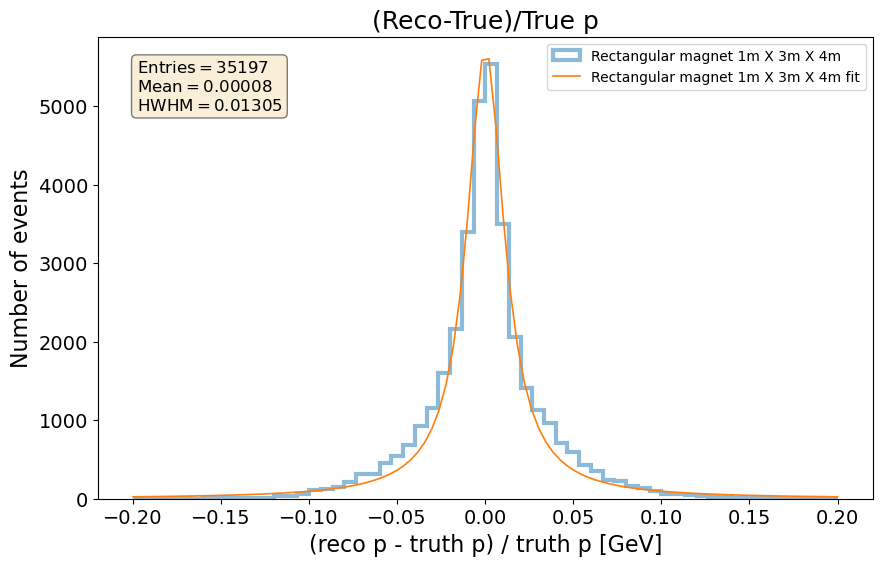

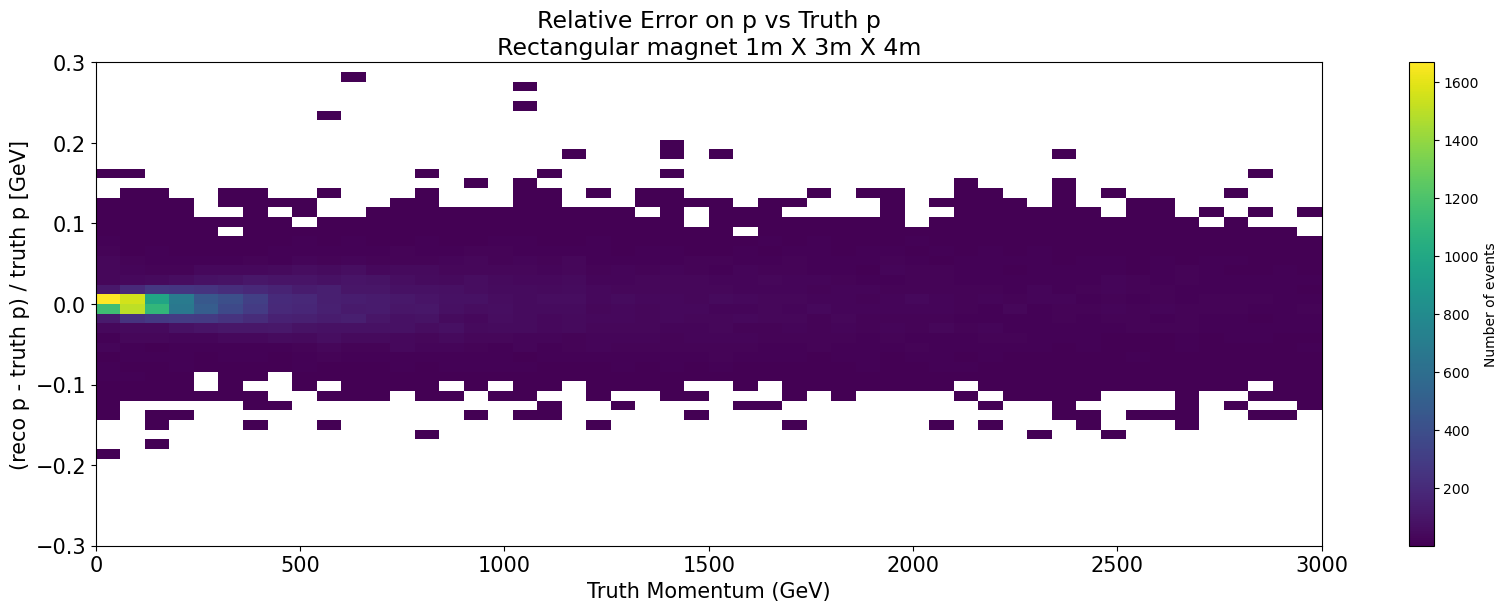

In [96]:

def plot_histogram_and_2d_with_cauchy(file_info_example):
    fig, ax = plt.subplots(figsize=(10, 6))

    for key, file_info in file_info_example.items():
        filename_Fit_1 = file_info['filename']
        info = file_info['info']

        Fit_1 = reco_analysis_momentum(filename_Fit_1)
        Fit_1_p = Fit_1['t_p_1d']
        Fit_1_p_res_rel = Fit_1['res_rela_p']

        # Filter the data to be within the desired range
        filtered_data = Fit_1_p_res_rel[(Fit_1_p_res_rel >= -0.2) & (Fit_1_p_res_rel <= 0.2)]

        # Plot histogram
        n, bins, patches = ax.hist(filtered_data, bins=60, range=(-0.2, 0.2), alpha=0.5, histtype='step', linewidth=3, label=info)

        # Cauchy fit for the filtered data
        (loc, scale) = cauchy.fit(filtered_data)

        # Create a Cauchy function of the fit
        x = np.linspace(-0.2, 0.2, 100)
        p = cauchy.pdf(x, loc, scale)
        ax.plot(x, p * len(filtered_data) * (bins[1] - bins[0]), linewidth=1.2, label=f'{info} fit')
        textstr = '\n'.join((
            r'$\mathrm{Entries}=%.0f$' % (len(filtered_data), ),
            r'$\mathrm{Mean}=%.5f$' % (loc, ),
            r'$\mathrm{HWHM}=%.5f$' % (scale, )))
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    title = "(Reco-True)/True p"
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('(reco p - truth p) / truth p [GeV]', fontsize=16)
    ax.set_ylabel('Number of events', fontsize=16)
    ax.legend()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    # Create subplots for 2D histograms
    num_files = len(file_info_example)
    fig, axs = plt.subplots(1, num_files, figsize=(15, 6), constrained_layout=True)
    axs = np.atleast_1d(axs)  # Ensure axs is always iterable

    for ax, (key, file_info) in zip(axs, file_info_example.items()):
        filename_Fit_1 = file_info['filename']
        info = file_info['info']

        Fit_1 = reco_analysis_mass_comp(filename_Fit_1)
        Fit_1_p = Fit_1['t_p_1d']
        Fit_1_p_res_rel = Fit_1['res_rela_p']

        h = ax.hist2d(Fit_1_p, Fit_1_p_res_rel, bins=[50, 50], range=[[0, 3000], [-0.3, 0.3]], cmin=1)
        ax.set_xlabel('Truth Momentum (GeV)', fontsize=15)
        ax.set_ylabel('(reco p - truth p) / truth p [GeV]', fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f'Relative Error on p vs Truth p\n{info}', fontsize=17)

        # Add a colorbar to show the number of events in each bin
        cbar = plt.colorbar(h[3], ax=ax)
        cbar.set_label('Number of events')

    plt.show()

# Example usage
plot_histogram_and_2d_with_cauchy(file_info_example)

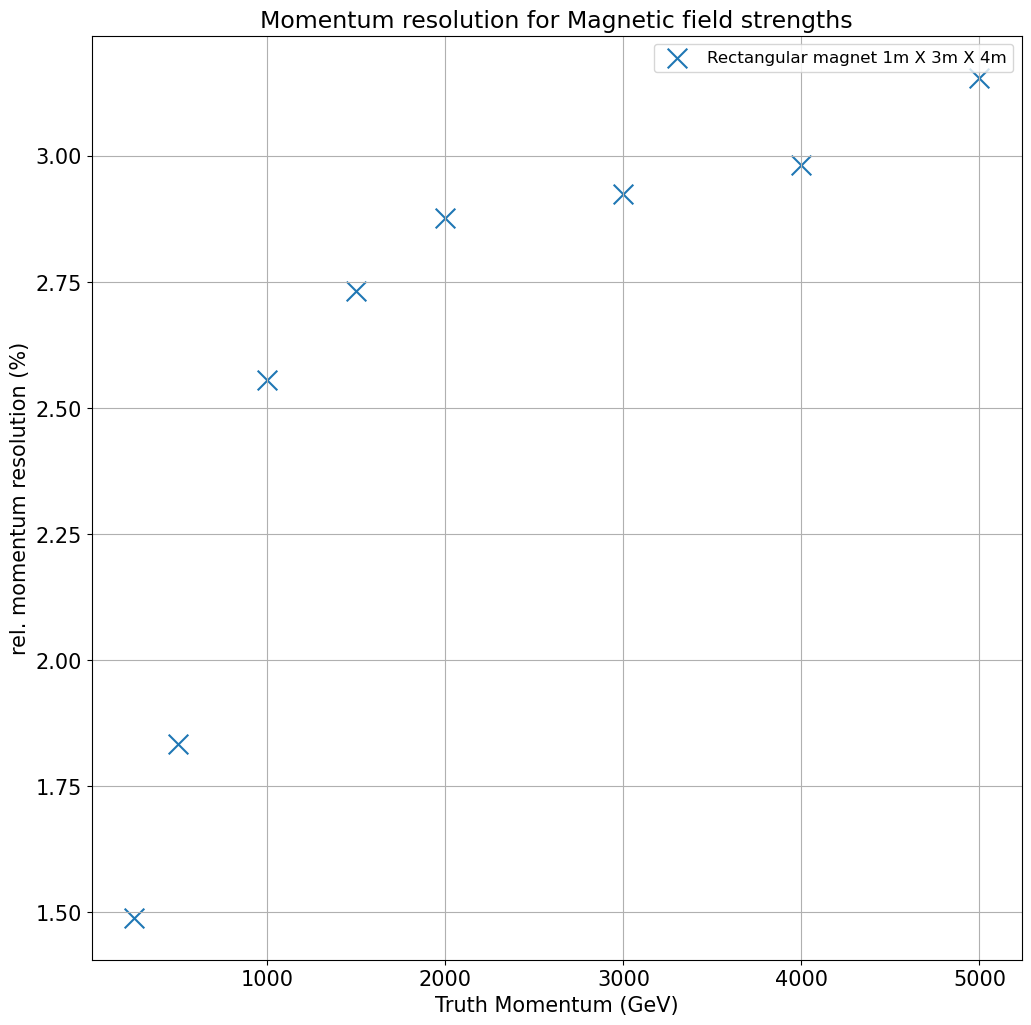

In [97]:

def mom_resolution(file_info, Plots_):
    """
    Function to plot momentum resolution based on provided file info and plotting parameters.
    """
    p_value = [250, 500, 1000, 1500, 2000, 3000, 4000, 5000]
    fig, ax = plt.subplots(figsize=Plots_['figSiz'])
    
    # Iterate over filenames in the provided dictionary
    for idx, (key, value) in enumerate(file_info.items()):
        filename_ = value['filename']
        info = value['info']

        # Assuming 'reco_analysis_mass_comp' is a previously defined function
        Fit_1 = reco_analysis_momentum(filename_,)
        Fit_1_p = Fit_1['t_p_1d']
        Fit_1_p_res_rel = Fit_1['res_rel_p']

        mean_errors = []
        for p in p_value:
            # Define the mask to filter data points within on p because it is a distribution in p and not a single values
            mask = (np.abs(Fit_1_p - p) < 200) & (Fit_1_p_res_rel < 1)
            # Filter arrays using the mask
            Fit_1_p_res_rel_mom = Fit_1_p_res_rel[mask]
            
            # Compute mean error and append to list
            mean_errors.append(np.std(100 * Fit_1_p_res_rel_mom))
        
        # Scatter plot for the computed mean errors
        ax.scatter(p_value, mean_errors, marker='x', s=200, label=info)

    # Set plot properties
    ax.set_xlabel('Truth Momentum (GeV)', fontsize=Plots_['font_size'])
    ax.set_ylabel('rel. momentum resolution (%)', fontsize=Plots_['font_size'])
    ax.tick_params(axis='both', which='major', labelsize=Plots_['font_size'])
    ax.set_title('Momentum resolution for Magnetic field strengths', fontsize=Plots_['font_size']+2)
    ax.grid(True)
    ax.legend(fontsize=Plots_['font_size']-3)
    
    # Uncomment the next line if you wish to save the plot
    # plt.savefig('path_to_save.jpg', format='jpg', dpi=150)
    
    plt.show()

# Call the function using the file_info_example
mom_resolution(file_info_example, PLOTS_)

### Plot of the mass resolution

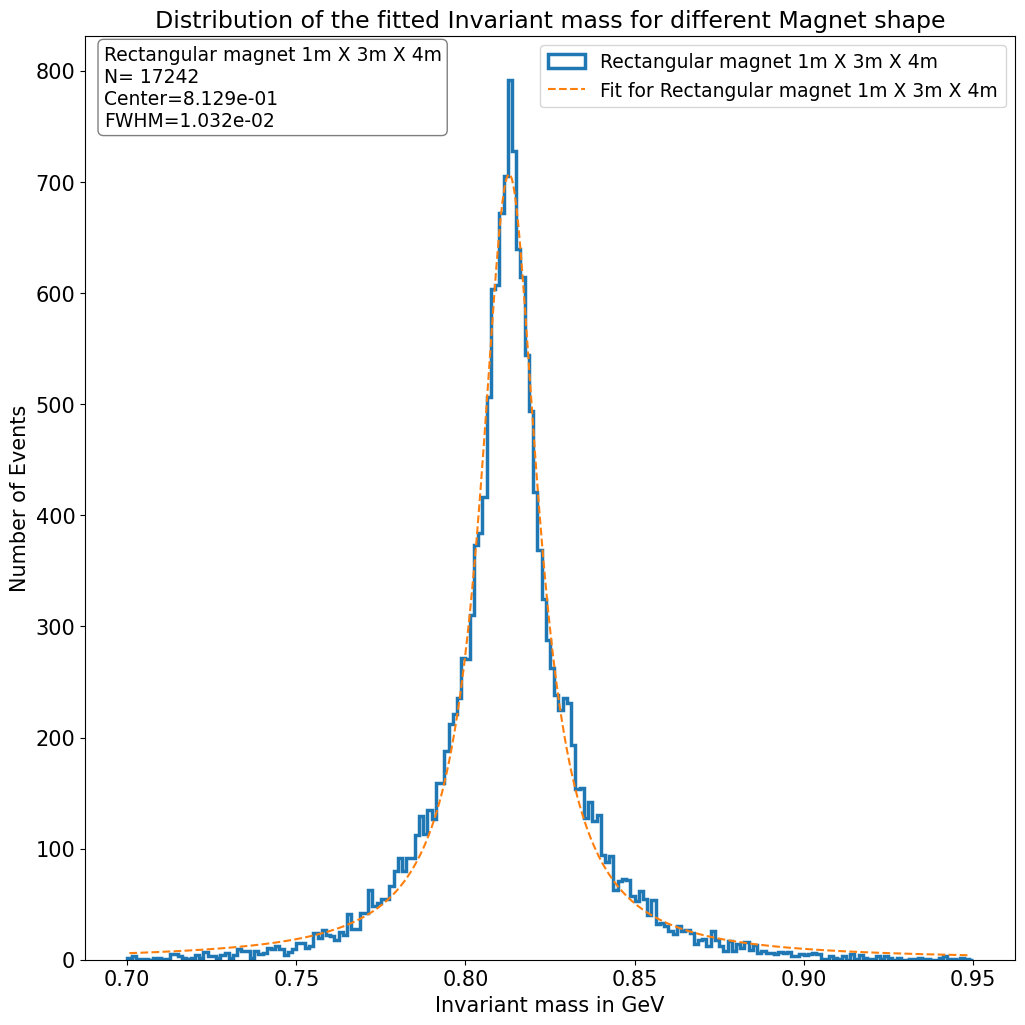

In [98]:
# Gaussian function definition
def gaussian(x, norm, mean, stddev):
    return norm * np.exp(-(x - mean)**2 / (2 * stddev**2))

# Cauchy function definition
def cauchy(x, norm, x0, gamma):
    return norm * (1/np.pi) * (gamma / ((x - x0)**2 + gamma**2))

def fit_comp_fits(file_keys, file_info, title, range_m, Plots_, fit_type="gaussian",fit_plt=False,Decay_LLP=True):


    if fit_type not in ["gaussian", "cauchy"]:
        print("fit_type should be either 'gaussian' or 'cauchy'")
        return

    fig, axs = plt.subplots(figsize=Plots_['figSiz'])

    for idx, key in enumerate(file_keys):
        fit_data = reco_analysis(file_info[key]['filename'],LLP_decay=Decay_LLP)  # Only be used for LLP decay
        mass_data = fit_data['m_fit']

        # Create histogram data
        hist_vals, bin_edges, _ = axs.hist(mass_data, bins=Plots_['bin_number'], range=range_m, label=file_info[key]['info'], histtype='step', linewidth=Plots_['linewidth'])
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        if fit_type == "gaussian":
            popt, _ = curve_fit(gaussian, bin_centers, hist_vals, p0=[max(hist_vals), np.mean(mass_data), np.std(mass_data)])
            fit_func = gaussian
            fit_params = {"norm": popt[0], "mean": popt[1], "stddev": popt[2]}
        else:
            popt, _ = curve_fit(cauchy, bin_centers, hist_vals, p0=[max(hist_vals), np.median(mass_data), 0.1])
            fit_func = cauchy
            fit_params = {"norm": popt[0], "x0": popt[1], "gamma": popt[2]}

        # Plot the fit results
        xs = np.linspace(bin_centers[0], bin_centers[-1], 1000)
        if fit_plt:
            axs.plot(xs, fit_func(xs, *popt), label=f'Fit for {file_info[key]["info"]}', linestyle="--")

        # Display fit parameters
        if fit_type == "gaussian":
            text_info = f"{file_info[key]['info']}\nN= {len(mass_data)}\nMean={fit_params['mean']:.3e}\nStdDev={fit_params['stddev']:.3e}"
        else:
            text_info = f"{file_info[key]['info']}\nN= {len(mass_data)}\nCenter={fit_params['x0']:.3e}\nFWHM={fit_params['gamma']:.3e}"
        
        position = 0.99 - (0.12 * idx)
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs.text(0.02, position, text_info, transform=axs.transAxes, ha='left', va='top', fontsize=Plots_['font_size']-1.5, bbox=props)

    axs.set_xlabel("Invariant mass in GeV", fontsize=Plots_['font_size'])
    axs.set_ylabel("Number of Events", fontsize=Plots_['font_size'])
    axs.tick_params(axis='both', which='major', labelsize=Plots_['font_size'])
    axs.set_title(title, fontsize=Plots_['font_size']+2)

    axs.legend(fontsize=Plots_['font_size']-1.5)
    plt.show()


fit_comp_fits(['Rect'], file_info_example, title_fits, range_m, PLOTS_, fit_type="cauchy",fit_plt=True)